# Iterative-RAKI for pre-scan calibration 
This notebook reconstructs a 4-fold undersampled 2D image using a pre-scan of different contrast as Auto-Calibration-Signal (ACS). For comparison, it also provides a GRAPPA and standard RAKI reconstruction. 

In [1]:
import numpy as np 
import sigpy as sp
import pathlib

from matplotlib import pyplot as plt

from cnn.rakiModels import rakiReco, irakiReco
from grappa.grappaReco import grappa

First, the zero-filled k-space and the sampling mask is loaded. This code assumes multi-channel 2D k-space in shape (coils, PE, RO), with PE: Phase-Encoding direction and RO: Read-Out direction.

In [2]:
DATADIR = pathlib.Path('./data/') # directory to k-space data and sampling mask
assert DATADIR.is_dir(), 'expected data directory non-existent'
file_name = 'preScanR4' # filename prospective 4-fold undersampled k-space
file_name_acs = 'preScanRefData'# filename fully sampled reference

In [3]:
acs_flag = 0 # for prescan calibration, the acs can not be put back into reconstructed k-space 

#assuming kspace in shape [coils, phase-enc, read-out-enc]
kspace_zf = np.load(DATADIR / (file_name + '.npy')) 
ipat = np.load(DATADIR / (file_name + '_ipat.npy')) 
# check k-space scaling such that minimum signal has order of magnitude 0       
scaling = np.floor(np.log10(np.min(np.abs(kspace_zf[np.where(kspace_zf!=0)]))))
kspace_zf *= 10**(-1*int(scaling))

acq = np.where(ipat[:,0]==1)[0] # get index of first non-zero sample
kspace_zf = kspace_zf[:,acq[0]:,:] # the code does not allow for leading zeros 
ipat = ipat[acq[0]:,:]

(nC, nP, nR) = kspace_zf.shape # (coils, number phase encoding lines, number read out lines)

R = acq[1] - acq[0] # acceleration factor 

Lets visualize the undersampled image and the sampling mask. 

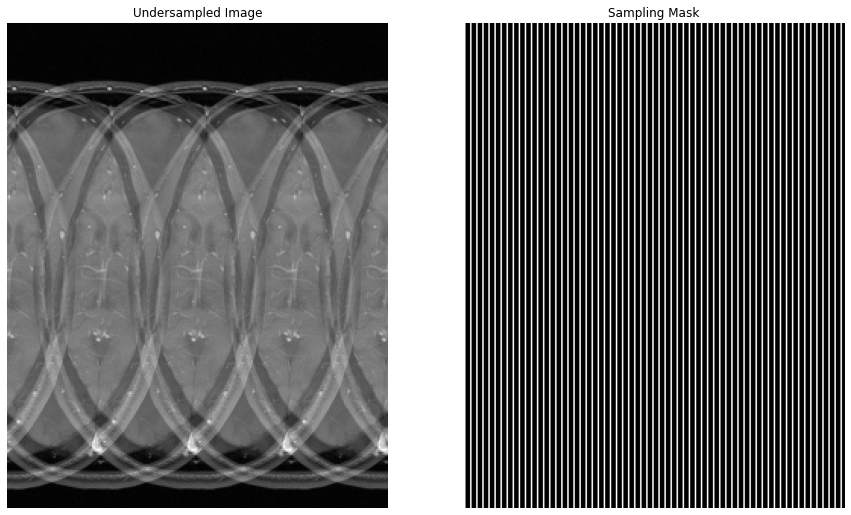

In [4]:
img_zf = sp.rss(sp.ifft(kspace_zf,axes=[1,2]),0)
fig, axs = plt.subplots(1,2, figsize=[15,30])
axs[0].imshow(np.abs(np.rot90(img_zf)),cmap='gray')
axs[1].imshow(np.rot90(ipat),cmap='gray')
axs[0].set_title('Undersampled Image')
axs[1].set_title('Sampling Mask')
for jj in range(2):
    axs[jj].axis('off')

Lets get the ACS from the pre-scan. It has a different contrast than the target image. 

In [5]:
acs_start = np.nan
acs_end = np.nan
acs = np.load(DATADIR / (file_name_acs + '.npy'))
# check k-space scaling such that minimum signal has order of magnitude 0   
scaling = np.floor(np.log10(np.min(np.abs(acs[np.where(acs!=0)]))))
acs *= 10**(-1*int(scaling))

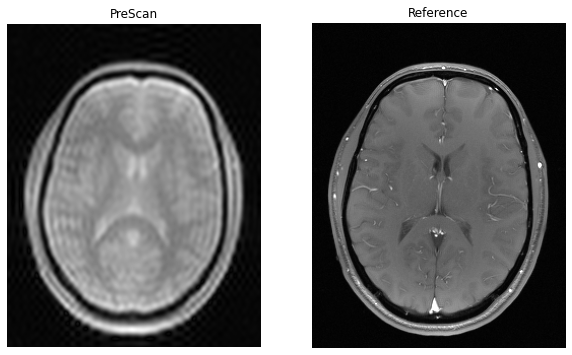

In [6]:
ref = ref = np.load(DATADIR / 'ref1456.npy') # load fully sampled reference image 
ref = np.flip(ref,axis=0)

# visualize prescan in comparison to target image 
(_,nP_,nR_) = acs.shape 
dP = int((nP-nP_)//2)
dR = int((nR-nR_)//2)

acsFFT = sp.rss(sp.ifft(acs,axes=[1,2]),0)
tmp = acsFFT
acsFFT = np.zeros((nP,nR),dtype=complex)
acsFFT[dP:dP+nP_,dR:dR+nR_] = sp.fft(tmp, axes=[0,1])
acsFFT = sp.ifft(acsFFT, axes=[0,1])

fig, axs = plt.subplots(1,2,figsize=[10,10])
axs[0].imshow(np.abs(np.rot90(acsFFT)),cmap='gray')
axs[1].imshow(np.abs(np.rot90(ref)),cmap='gray', vmax=0.6*np.max(np.abs(ref)))
axs[0].set_title('PreScan')
axs[1].set_title('Reference')
for jj in range(2):
    axs[jj].axis('off')

Now we build the RAKI-Network. The dictionary 'layer_design_raki' specifies its architechture.  

In [7]:
layer_design_raki = {'num_hid_layer': 2, # number of hidden layers, in this case, its 2
                     'input_unit': nC, # number channels in input layer, nC is coil number 
                        1:[256,(2,5)], # the first hidden layer has 256 channels, and a kernel size of (2,5) in PE- and RO-direction
                        2:[128,(1,1)], # the second hidden layer has 128 channels, and a kernel size of (1,1) in PE- and RO-direction
                    'output_unit':[(R-1)*nC,(1,5)] # the output layer has (R-1)*nC channels, and a kernel size of (1,5) in PE- and RO-direction
                    }

raki_reco = rakiReco(np.copy(kspace_zf), acs, R, layer_design_raki) # get standard RAKI reconstruction

if acs_flag: # in the pre-scan calibration, the acs is not re-inserted into reconstructed k-space
    raki_reco[:, acs_start:acs_end+1,:] = acs


  0%|          | 0/500 [00:00<?, ?it/s]

Starting Standard RAKI...


100%|██████████| 500/500 [01:20<00:00,  6.19it/s]


Finished Standard RAKI...


Now lets do the GRAPPA reconstruction.

In [8]:
grappa_reco = grappa(np.copy(kspace_zf), acs, R, {'phase': 2, 'read':5} , 0.0001)

if acs_flag:
    grappa_reco[:, acs_start:acs_end+1,:] = acs

Loading Source - & Target Matrix ... 
Done 

Took  0.017  sec 

GRAPPA Weights Calculation...
Done 

Took  0.32 sec 



For iterative-RAKI, the kernel size assigned to the first hidden layer is increased from (2,5) to (4,7) in PE- and RO-direction, respectively.

In [9]:
layer_design_iraki = {'num_hid_layer': 2, # number of hidden layers, in this case, its 2
                      'input_unit': nC, # number channels in input layer, nC is coil number 
                        1:[256,(4,7)], # the first hidden layer has 256 channels, and a kernel size of (4,7) in PE- and RO-direction
                        2:[128,(1,1)],  # the second hidden layer has 128 channels, and a kernel size of (1,1) in PE- and RO-direction
                      'output_unit':[(R-1)*nC,(1,5)] # the output layer has (R-1)*nC channels, and a kernel size of (1,5) in PE- and RO-direction
                        }

iraki_reco = irakiReco(np.copy(kspace_zf), acs, R, layer_design_iraki, grappa_reco, acs_flag, acs_start, acs_end) 


  0%|          | 0/500 [00:00<?, ?it/s]

Starting Iterative RAKI...
Iteration  1  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  2  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  3  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  4  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  5  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  6  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  7  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  8  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  9  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  10  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  11  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  12  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  13  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  14  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  15  of  16


  0%|          | 0/250 [00:00<?, ?it/s]

Iteration  16  of  16


100%|██████████| 250/250 [01:04<00:00,  3.90it/s]


Finished Iterative RAKI...


Text(0.5, 1.0, 'iRAKI')

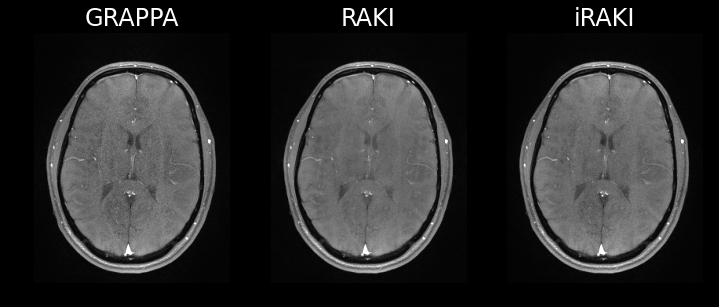

In [11]:
raki_recoFFT = sp.ifft(raki_reco, axes=[1, 2])
raki_recoFFT = sp.rss(raki_recoFFT, 0)  

grappa_recoFFT = sp.ifft(grappa_reco, axes=[1, 2])
grappa_recoFFT = sp.rss(grappa_recoFFT, 0)  

iraki_recoFFT = sp.ifft(iraki_reco, axes=[1, 2])
iraki_recoFFT = sp.rss(iraki_recoFFT, 0)  

max_rss = np.max(np.abs(grappa_recoFFT))
alpha = 0.6
diffScaling = 1e1

font = {'fontsize':24, 'color': 'white'}
fig, axs = plt.subplots(1,3,figsize=[12,6], facecolor='k')
axs[0].imshow(np.abs(np.rot90(grappa_recoFFT)), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[1].imshow(np.abs(np.rot90(raki_recoFFT)), cmap='gray', vmin=0, vmax=max_rss*alpha)
axs[2].imshow(np.abs(np.rot90(iraki_recoFFT)), cmap='gray', vmin=0, vmax=max_rss*alpha)

axs[0].set_title('GRAPPA', fontdict=font)
axs[1].set_title('RAKI', fontdict=font)
axs[2].set_title('iRAKI', fontdict=font)